# Reacher

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

Make sure that you're in the right virtual environment and the right python version.

In [2]:
!python --version
import platform
platform.system()

Python 3.6.9 :: Anaconda, Inc.


'Linux'

The environment is already saved in the Workspace and can be accessed at the file path provided below.  Please run the next code cell without making any changes.

In [3]:
from unityagents import UnityEnvironment
import matplotlib.pyplot as plt
import sys
from collections import deque
import timeit
from datetime import timedelta
from copy import deepcopy
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

if platform.system() == "Windows":
    env = UnityEnvironment(file_name="data/Reacher_Windows_x86_64/Reacher.exe")
if platform.system() == "Linux":
    env = UnityEnvironment(file_name="data/Reacher_Linux/Reacher.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Actor-Critic implementation

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def build_hidden_layer(input_dim, hidden_layers):
    """Build hidden layer.
    Params
    ======
        input_dim (int): Dimension of hidden layer input
        hidden_layers (list(int)): Dimension of hidden layers
    """
    hidden = nn.ModuleList([nn.Linear(input_dim, hidden_layers[0])])
    if len(hidden_layers)>1:
        layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:])
        hidden.extend([nn.Linear(h1, h2) for h1, h2 in layer_sizes])
    return hidden

class ActorCritic(nn.Module):
    def __init__(self,state_size,action_size,shared_layers,
                 critic_hidden_layers=[],actor_hidden_layers=[],
                 seed=0, init_type=None):
        """Initialize parameters and build policy.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            shared_layers (list(int)): Dimension of the shared hidden layers
            critic_hidden_layers (list(int)): Dimension of the critic's hidden layers
            actor_hidden_layers (list(int)): Dimension of the actor's hidden layers
            seed (int): Random seed
            init_type (str): Initialization type
        """
        super(ActorCritic, self).__init__()
        self.init_type = init_type
        self.seed = torch.manual_seed(seed)
        self.sigma = nn.Parameter(torch.zeros(action_size))

        # Add shared hidden layer
        self.shared_layers = build_hidden_layer(input_dim=state_size,
                                                hidden_layers=shared_layers)

        # Add critic layers
        if critic_hidden_layers:
            # Add hidden layers for critic net if critic_hidden_layers is not empty
            self.critic_hidden = build_hidden_layer(input_dim=shared_layers[-1],
                                                    hidden_layers=critic_hidden_layers)
            self.critic = nn.Linear(critic_hidden_layers[-1], 1)
        else:
            self.critic_hidden = None
            self.critic = nn.Linear(shared_layers[-1], 1)

        # Add actor layers
        if actor_hidden_layers:
            # Add hidden layers for actor net if actor_hidden_layers is not empty
            self.actor_hidden = build_hidden_layer(input_dim=shared_layers[-1],
                                                   hidden_layers=actor_hidden_layers)
            self.actor = nn.Linear(actor_hidden_layers[-1], action_size)
        else:
            self.actor_hidden = None
            self.actor = nn.Linear(shared_layers[-1], action_size)

        # Apply Tanh() to bound the actions
        self.tanh = nn.Tanh()

        # Initialize hidden and actor-critic layers
        if self.init_type is not None:
            self.shared_layers.apply(self._initialize)
            self.critic.apply(self._initialize)
            self.actor.apply(self._initialize)
            if self.critic_hidden is not None:
                self.critic_hidden.apply(self._initialize)
            if self.actor_hidden is not None:
                self.actor_hidden.apply(self._initialize)

    def _initialize(self, n):
        """Initialize network weights.
        """
        if isinstance(n, nn.Linear):
            if self.init_type=='xavier-uniform':
                nn.init.xavier_uniform_(n.weight.data)
            elif self.init_type=='xavier-normal':
                nn.init.xavier_normal_(n.weight.data)
            elif self.init_type=='kaiming-uniform':
                nn.init.kaiming_uniform_(n.weight.data)
            elif self.init_type=='kaiming-normal':
                nn.init.kaiming_normal_(n.weight.data)
            elif self.init_type=='orthogonal':
                nn.init.orthogonal_(n.weight.data)
            elif self.init_type=='uniform':
                nn.init.uniform_(n.weight.data)
            elif self.init_type=='normal':
                nn.init.normal_(n.weight.data)
            else:
                raise KeyError('initialization type is not found in the set of existing types')

    def forward(self, state):
        """Build a network that maps state -> (action, value)."""
        def apply_multi_layer(layers,x,f=F.leaky_relu):
            for layer in layers:
                x = f(layer(x))
            return x

        state = apply_multi_layer(self.shared_layers,state)

        v_hid = state
        if self.critic_hidden is not None:
            v_hid = apply_multi_layer(self.critic_hidden,v_hid)

        a_hid = state
        if self.actor_hidden is not None:
            a_hid = apply_multi_layer(self.actor_hidden,a_hid)

        a = self.tanh(self.actor(a_hid))
        value = self.critic(v_hid).squeeze(-1)
        return a, value

Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [5]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
env_info = env.reset(train_mode=True)[brain_name]
num_agents = len(env_info.agents)
action_size = brain.vector_action_space_size
state_size = env_info.vector_observations.shape[1]

Examine the state and action spaces.

In [6]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  7.90150833e+00 -1.00000000e+00
  1.25147629e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -5.22214413e-01]


In [7]:
device = torch.device("cpu")#"cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [8]:
def collect_trajectories(envs, policy, tmax=200, nrand=5, train_mode=False):

    def to_tensor(x, dtype=np.float32):
        return torch.from_numpy(np.array(x).astype(dtype)).to(device)

    #initialize returning lists and start the game!
    state_list=[]
    reward_list=[]
    prob_list=[]
    action_list=[]
    value_list=[]
    done_list=[]

    env_info = envs.reset(train_mode=train_mode)[brain_name]

    # perform nrand random steps
    for _ in range(nrand):
        action = np.random.randn(num_agents, action_size)
        action = np.clip(action, -1.0, 1.0)
        env_info = envs.step(action)[brain_name]

    for t in range(tmax):
        states = to_tensor(env_info.vector_observations)
        action_est, values = policy(states)
        sigma = nn.Parameter(torch.zeros(action_size))
        dist = torch.distributions.Normal(action_est, F.softplus(sigma).to(device))
        actions = dist.sample()
        log_probs = dist.log_prob(actions)
        log_probs = torch.sum(log_probs, dim=-1).detach()
        values = values.detach()
        actions = actions.detach()

        env_actions = actions.cpu().numpy()
        env_info = envs.step(env_actions)[brain_name]
        rewards = to_tensor(env_info.rewards)
        dones = to_tensor(env_info.local_done, dtype=np.uint8)

        state_list.append(states.unsqueeze(0))
        prob_list.append(log_probs.unsqueeze(0))
        action_list.append(actions.unsqueeze(0))
        reward_list.append(rewards.unsqueeze(0))
        value_list.append(values.unsqueeze(0))
        done_list.append(dones.unsqueeze(0))
        #if np.any(dones.cpu().numpy()):
        if np.any(dones.numpy()):
            env_info = envs.reset(train_mode=train_mode)[brain_name]

    state_list = torch.cat(state_list, dim=0)
    prob_list = torch.cat(prob_list, dim=0)
    action_list = torch.cat(action_list, dim=0)
    reward_list = torch.cat(reward_list, dim=0)
    value_list = torch.cat(value_list, dim=0)
    done_list = torch.cat(done_list, dim=0)
    return prob_list, state_list, action_list, reward_list, value_list, done_list

In [9]:
def calc_returns(rewards, values, dones):
    n_step = len(rewards)
    n_agent = len(rewards[0])

    # Create empty buffer
    GAE = torch.zeros(n_step,n_agent).float().to(device)
    returns = torch.zeros(n_step,n_agent).float().to(device)

    # Set start values
    GAE_current = torch.zeros(n_agent).float().to(device)

    TAU = 0.95
    discount = 0.99
    values_next = values[-1].detach()
    returns_current = values[-1].detach()
    for irow in reversed(range(n_step)):
        values_current = values[irow]
        rewards_current = rewards[irow]
        gamma = discount * (1. - dones[irow].float())

        # Calculate TD Error
        td_error = rewards_current + gamma * values_next - values_current
        # Update GAE, returns
        GAE_current = td_error + gamma * TAU * GAE_current
        returns_current = rewards_current + gamma * returns_current
        # Set GAE, returns to buffer
        GAE[irow] = GAE_current
        returns[irow] = returns_current

        values_next = values_current

    return GAE, returns


In [10]:
def eval_policy(envs, policy, tmax=1000):
    reward_list=[]
    env_info = envs.reset(train_mode=False)[brain_name]
    for t in range(tmax):
        states = torch.from_numpy(env_info.vector_observations).float().to(device)
        action_est, values = policy(states)
        sigma = nn.Parameter(torch.zeros(action_size))
        dist = torch.distributions.Normal(action_est, F.softplus(sigma).to(device))
        actions = dist.sample()
        env_actions = actions.cpu().numpy()
        env_info = envs.step(env_actions)[brain_name]
        reward = env_info.rewards
        dones = env_info.local_done
        reward_list.append(np.mean(reward))

        # stop if any of the trajectories is done to have retangular lists
        if np.any(dones):
            break
    return reward_list

## Network Architecture
An actor-critic structure with continuous action space is used for this project. The policy consists of 3 parts, a shared hidden layers, actor, and critic.
The actor layer outputs the mean value of a normal distribution, from which the agent's action is sampled. The critic layer yields the value function.

- Shared layer:
```
Input State(33) -> Dense(128) -> LeakyReLU -> Dense(128) -> LeakyReLU*
```
- Actor and Critic layers:
```
LeakyRelu* -> Dense(64) -> LeakyRelu -> Dense(4)-> tanh -> Actor's output
LeakyReLU* -> Dense(64) -> LeakyRelu -> Dense(1) -> Critic's output
```

### Model update using PPO/GAE
The hyperparameters used during training are:

Parameter | Value | Description
------------ | ------------- | -------------
Number of Agents | 20 | Number of agents trained simultaneously
Episodes | 2000 | Maximum number of training episodes
tmax | 1000 | Maximum number of steps per episode
Epochs | 10 | Number of training epoch per batch sampling
Batch size | 128*20 | Size of batch taken from the accumulated  trajectories
Discount (gamma) | 0.99 | Discount rate 
Epsilon | 0.1 | Ratio used to clip r = new_probs/old_probs during training
Gradient clip | 10.0 | Maximum gradient norm 
Beta | 0.01 | Entropy coefficient 
Tau | 0.95 | tau coefficient in GAE
Learning rate | 2e-4 | Learning rate 
Optimizer | Adam | Optimization method


In [11]:
# run your own policy!
policy=ActorCritic(state_size=state_size,
              action_size=action_size,
              shared_layers=[128, 64],
              critic_hidden_layers=[],
              actor_hidden_layers=[],
              init_type='xavier-uniform',
              seed=0).to(device)

# we use the adam optimizer with learning rate 2e-4
# optim.SGD is also possible
optimizer = optim.Adam(policy.parameters(), lr=2e-4)

In [12]:
scores_window = deque(maxlen=100)  # last 100 scores

discount = 0.993
epsilon = 0.07
beta = .01
opt_epoch = 10
episode = 2000
batch_size = 128
tmax = 1000 #env episode steps
save_scores = []
print_per_n = min(10,episode/10)
counter = 0
start_time = timeit.default_timer()

for e in range(episode):
    policy.eval()
    old_probs_lst, states_lst, actions_lst, rewards_lst, values_lst, dones_list = collect_trajectories(envs=env,
                                                                                                       policy=policy,
                                                                                                       tmax=tmax,
                                                                                                       nrand = 0,
                                                                                                       train_mode=True)

    avg_score = rewards_lst.sum(dim=0).mean().item()
    scores_window.append(avg_score)
    save_scores.append(avg_score)
    
    gea, target_value = calc_returns(rewards = rewards_lst,
                                     values = values_lst,
                                     dones=dones_list)
    gea = (gea - gea.mean()) / (gea.std() + 1e-8)

    policy.train()

    # cat all agents
    def concat_all(v):
        if len(v.shape) == 3:
            return v.reshape([-1, v.shape[-1]])
        return v.reshape([-1])

    old_probs_lst = concat_all(old_probs_lst)
    states_lst = concat_all(states_lst)
    actions_lst = concat_all(actions_lst)
    rewards_lst = concat_all(rewards_lst)
    values_lst = concat_all(values_lst)
    gea = concat_all(gea)
    target_value = concat_all(target_value)

    # gradient ascent step
    n_sample = len(old_probs_lst)//batch_size
    idx = np.arange(len(old_probs_lst))
    np.random.shuffle(idx)
    for epoch in range(opt_epoch):
        for b in range(n_sample):
            ind = idx[b*batch_size:(b+1)*batch_size]
            g = gea[ind]
            tv = target_value[ind]
            actions = actions_lst[ind]
            old_probs = old_probs_lst[ind]

            action_est, values = policy(states_lst[ind])
            sigma = nn.Parameter(torch.zeros(action_size))
            dist = torch.distributions.Normal(action_est, F.softplus(sigma).to(device))
            log_probs = dist.log_prob(actions)
            log_probs = torch.sum(log_probs, dim=-1)
            entropy = torch.sum(dist.entropy(), dim=-1)

            ratio = torch.exp(log_probs - old_probs)
            ratio_clipped = torch.clamp(ratio, 1 - epsilon, 1 + epsilon)
            L_CLIP = torch.mean(torch.min(ratio*g, ratio_clipped*g))
            # entropy bonus
            S = entropy.mean()
            # squared-error value function loss
            L_VF = 0.5 * (tv - values).pow(2).mean()
            # clipped surrogate
            L = -(L_CLIP - L_VF + beta*S)
            optimizer.zero_grad()
            # This may need retain_graph=True on the backward pass
            # as pytorch automatically frees the computational graph after
            # the backward pass to save memory
            # Without this, the chain of derivative may get lost
            L.backward(retain_graph=True)
            torch.nn.utils.clip_grad_norm_(policy.parameters(), 10.0)
            optimizer.step()
            del(L)

    # the clipping parameter reduces as time goes on
    epsilon*=.999
    
    # the regulation term also reduces
    # this reduces exploration in later runs
    beta*=.998
    
    # display some progress every n iterations
    if (e+1)%print_per_n ==0 :
        print("Episode: {0:d}, average score: {1:.2f}".format(e+1,np.mean(scores_window)), end="\n")
    else:
        print("Episode: {0:d}, score: {1:.2f}".format(e+1, avg_score), end="\r")
    if np.mean(scores_window)<5.0:
        counter = 0# stop if any of the trajectories is done to have retangular lists
    if e>=25 and np.mean(scores_window)>30.0:
        print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(e+1, np.mean(scores_window)))
        break


print('Average Score: {:.2f}'.format(np.mean(scores_window)))
elapsed = timeit.default_timer() - start_time
print("Elapsed time: {}".format(timedelta(seconds=elapsed)))
print("Saving checkpoint!")
# save your policy!
torch.save(policy.state_dict(), 'checkpoint.pth')

Episode: 10, average score: 0.39
Episode: 20, average score: 0.44
Episode: 30, average score: 0.51
Episode: 40, average score: 0.59
Episode: 50, average score: 0.64
Episode: 60, average score: 0.71
Episode: 70, average score: 0.79
Episode: 80, average score: 0.86
Episode: 90, average score: 0.93
Episode: 100, average score: 1.03
Episode: 110, average score: 1.21
Episode: 120, average score: 1.41
Episode: 130, average score: 1.64
Episode: 140, average score: 1.89
Episode: 150, average score: 2.16
Episode: 160, average score: 2.47
Episode: 170, average score: 2.81
Episode: 180, average score: 3.21
Episode: 190, average score: 3.66
Episode: 200, average score: 4.15
Episode: 210, average score: 4.69
Episode: 220, average score: 5.34
Episode: 230, average score: 6.07
Episode: 240, average score: 6.99
Episode: 250, average score: 8.05
Episode: 260, average score: 9.17
Episode: 270, average score: 10.42
Episode: 280, average score: 11.78
Episode: 290, average score: 13.21
Episode: 300, averag

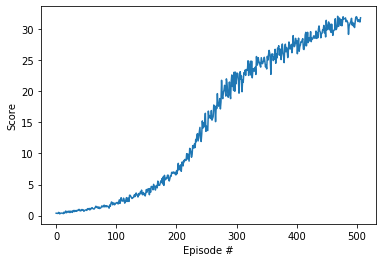

In [13]:
fig = plt.figure()
plt.plot(np.arange(len(save_scores)), save_scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

## 3. Evaluation

In [14]:
episode = 10
scores_window = deque(maxlen=100)  # last 100 scores

# load the model
policy.load_state_dict(torch.load('checkpoint.pth'))

# evaluate the model
for e in range(episode):
    rewards = eval_policy(envs=env, policy=policy, tmax=1000)
    total_rewards = np.sum(rewards,0)
    scores_window.append(total_rewards.mean())
    print("Episode: {0:d}, score: {1}".format(e+1, np.mean(scores_window)), end="\n")

Episode: 1, score: 29.83549933312461
Episode: 2, score: 31.321249299915507
Episode: 3, score: 31.412832631201795
Episode: 4, score: 31.35587429914158
Episode: 5, score: 31.43659929733723
Episode: 6, score: 31.491332629447182
Episode: 7, score: 31.5271421524563
Episode: 8, score: 31.64393679270288
Episode: 9, score: 31.733999290689823
Episode: 10, score: 31.759799290113154


In [15]:
env.close()

## Future Work
1. Hyperparameter optimization and analysis.
2. Studying the effect of clipping.